# preparing work

In [1]:
## Installing corresponding python packages & downloading model weights
# !pip install -r qwen_requirements.txt

# !cd model_weights
# !git lfs install
# !git clone https://hf-mirror.com/Qwen/Qwen-VL-Chat

# base vqa model

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
# Loading model from hugging face
# tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)
# model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="cuda", trust_remote_code=True).eval()

# Loading modle from local path
model_path = '/model_weights/Qwen-VL-Chat'
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="cuda", trust_remote_code=True).eval()

/home/ll_25113060022/anaconda3/envs/undergraduates_qwenvl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ll_25113060022/anaconda3/envs/undergraduates_qwenvl/lib/python3.10/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/ll_25113060022/anaconda3/envs/undergraduates_qwenvl/lib/python3.10/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
The model is automatically converting to bf16 for faster inference. If you want to disable the autom

In [3]:
from PIL import Image
import pandas as pd
img_path_head = '/cpfs01/projects-HDD/cfff-906dc71fafda_HDD/ll_25113060022/undergraduates_course_copy/hallucination/dataset/img_jpgs/'
dataset_csv_path = '/cpfs01/projects-HDD/cfff-906dc71fafda_HDD/ll_25113060022/undergraduates_course_copy/hallucination/dataset/vqa_info.csv'
df = pd.read_csv(dataset_csv_path)
df.iloc[:10,]

,img_path,question,answer
0,img_0.jpg,is there evidence of an aortic aneurysm?,yes
1,img_1.jpg,is there airspace consolidation on the left side?,yes
2,img_10.jpg,is there any intraparenchymal abnormalities in...,no
3,img_100.jpg,which side of the heart border is obscured?,right
4,img_101.jpg,where are the kidney?,not seen here
5,img_102.jpg,are the kidneys present in this image?,no
6,img_103.jpg,is the colon more prominent on the patient's r...,left
7,img_104.jpg,where is the colon most prominent from this view?,left
8,img_105.jpg,is the heart size in this image smaller or lar...,smaller
9,img_106.jpg,is the liver visible in the image?,no


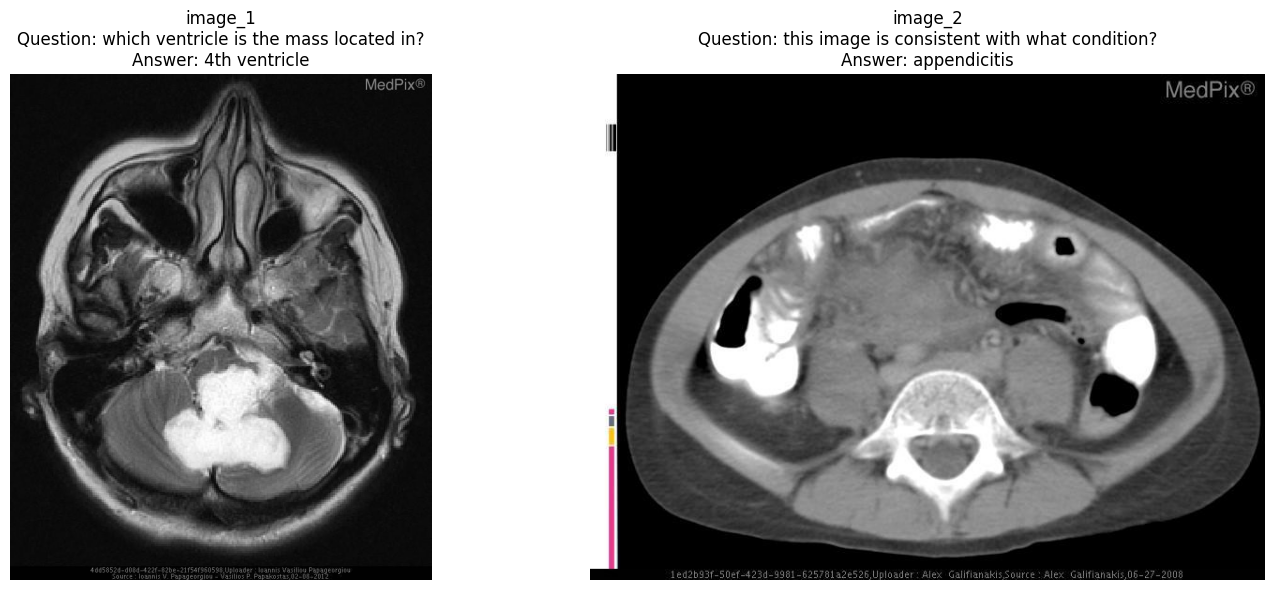

In [4]:
index_1, index_2 = 262, 384

image_path_1 = img_path_head+df['img_path'][index_1]
question_1, answer_1 = df['question'][index_1], df['answer'][index_1]
question_1_ = '<img>{}</img>{} Answer:'.format(image_path_1, question_1)

tokenizer.padding_side = 'left'
tokenizer.pad_token_id = tokenizer.eod_id
input_ids_1 = tokenizer([question_1_], return_tensors='pt', padding='longest')

#########################################################################################################################################
image_path_2 = img_path_head+df['img_path'][index_2]
question_2, answer_2 = df['question'][index_2], df['answer'][index_2]
question_2_ = '<img>{}</img>{} Answer:'.format(image_path_2, question_2)

tokenizer.padding_side = 'left'
tokenizer.pad_token_id = tokenizer.eod_id
input_ids_2 = tokenizer([question_2_], return_tensors='pt', padding='longest')

##########################################################################################################################################
import matplotlib.pyplot as plt
image_1 = Image.open(image_path_1).convert("RGB")
image_2 = Image.open(image_path_2).convert("RGB")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(image_1)
axes[0].set_title(f"image_1\nQuestion: {question_1}\nAnswer: {answer_1}")
axes[0].axis('off')
axes[1].imshow(image_2)
axes[1].set_title(f"image_2\nQuestion: {question_2}\nAnswer: {answer_2}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
outputs_1 = model.generate(
                            input_ids=input_ids_1.input_ids.cuda(),
                            attention_mask=input_ids_1.attention_mask.cuda(),
                            do_sample=False,
                            max_new_tokens=20,
                            min_new_tokens=1,
                            length_penalty=1,
                            num_return_sequences=1,
                            output_hidden_states=True,
                            use_cache=True,
                            pad_token_id=tokenizer.eod_id,
                            eos_token_id=tokenizer.eod_id,
                            temperature=1.0,
                            top_p=1,
                            top_k=None,
                            output_scores=True,  # 关键：启用分数输出
                            return_dict_in_generate=True  # 关键：返回结构化结果
                            )

predicting_answer_1 = [
                     tokenizer.decode(_[input_ids_1.input_ids.size(1):].cpu(),
                     skip_special_tokens=True).strip() for _ in outputs_1.sequences
                    ][0].strip()
print(f"{'*'*100}\nQuestion1: {question_1}\nAnswer1: {answer_1}\nPredict1: {predicting_answer_1}")

#############################################################################################
outputs_2 = model.generate(
                        input_ids=input_ids_2.input_ids.cuda(),
                        attention_mask=input_ids_2.attention_mask.cuda(),
                        do_sample=True,
                        max_new_tokens=20,
                        min_new_tokens=1,
                        length_penalty=1,
                        num_return_sequences=1,
                        output_hidden_states=True,
                        use_cache=True,
                        pad_token_id=tokenizer.eod_id,
                        eos_token_id=tokenizer.eod_id,
                        temperature=1.0,
                        top_p=1,
                        top_k=None,
                        output_scores=True,  # 关键：启用分数输出
                        return_dict_in_generate=True  # 关键：返回结构化结果
                        )

predicting_answer_2 = [
                     tokenizer.decode(_[input_ids_2.input_ids.size(1):].cpu(),
                     skip_special_tokens=True).strip() for _ in outputs_2.sequences
                    ][0].strip()
print(f"{'*'*100}\nQuestion2: {question_2}\nAnswer2: {answer_2}\nPredict2: {predicting_answer_2}")

/home/ll_25113060022/anaconda3/envs/undergraduates_qwenvl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:377: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


****************************************************************************************************
Question1: which ventricle is the mass located in?
Answer1: 4th ventricle
Predict1: fourth ventricle
****************************************************************************************************
Question2: this image is consistent with what condition?
Answer2: appendicitis
Predict2: hydronephrosis


# hallucination detection

In [6]:
import torch
import numpy as np

def softmax_1(x):
    # 避免数值溢出：减去最大值（沿第二个维度）
    x_max = np.max(x, axis=1, keepdims=True)
    x_exp = np.exp(x - x_max)
    
    # 计算Softmax分母（沿第二个维度求和）
    sum_exp = np.sum(x_exp, axis=1, keepdims=True)
    
    # 计算Softmax结果
    return x_exp / sum_exp

def compute_entropy(probabilities):
    """
    计算Softmax概率分布的熵
    
    参数:
        probabilities: 形状为(n, 3200)的numpy数组，表示概率分布
    
    返回:
        形状为(n, 1)的numpy数组，每行包含该行概率分布的熵值
    """
    # 计算对数概率（避免log(0)导致NaN）
    log_probs = np.zeros_like(probabilities)
    non_zero_mask = probabilities > 0
    log_probs[non_zero_mask] = np.log(probabilities[non_zero_mask])
    
    # 计算每行的熵：H = -Σ(p_i * log(p_i))
    entropy_per_row = -np.sum(probabilities * log_probs, axis=1, keepdims=True)
    
    return entropy_per_row

In [7]:
logits = torch.cat(outputs_1.scores, dim=0).float().cpu().detach().numpy()
prob = softmax_1(logits)
prob_max = np.max(prob, axis=1)
average_prob = np.mean(prob_max, axis=0)
maximum_prob = np.max(prob_max, axis=0)

entropy = compute_entropy(prob)
average_entropy = np.mean(entropy, axis=0)[0]
maximum_entropy = np.max(entropy, axis=0)[0]

print(f"{'*'*50}\nhallucination metirc of outputs_1:")
print(f"average probability = {average_prob}\nmaximum probability = {maximum_prob}")
print(f"average entropy = {average_entropy}\nmaximum entropy = {maximum_entropy}")

##############################################################################################
logits = torch.cat(outputs_2.scores, dim=0).float().cpu().detach().numpy()
prob = softmax_1(logits)
prob_max = np.max(prob, axis=1)
average_prob = np.mean(prob_max, axis=0)
maximum_prob = np.max(prob_max, axis=0)

entropy = compute_entropy(prob)
average_entropy = np.mean(entropy, axis=0)[0]
maximum_entropy = np.max(entropy, axis=0)[0]
print(f"{'*'*50}\nhallucination metirc of outputs_2:")
print(f"average probability = {average_prob}\nmaximum probability = {maximum_prob}")
print(f"average entropy = {average_entropy}\nmaximum entropy = {maximum_entropy}")

**************************************************
hallucination metirc of outputs_1:
average probability = 0.8835902214050293
maximum probability = 0.9999891519546509
average entropy = 0.4122808873653412
maximum entropy = 1.906251072883606
**************************************************
hallucination metirc of outputs_2:
average probability = 0.811636745929718
maximum probability = 0.999339759349823
average entropy = 1.2919089794158936
maximum entropy = 6.320765495300293


# visual contrasive decoding for hallucination mitigation
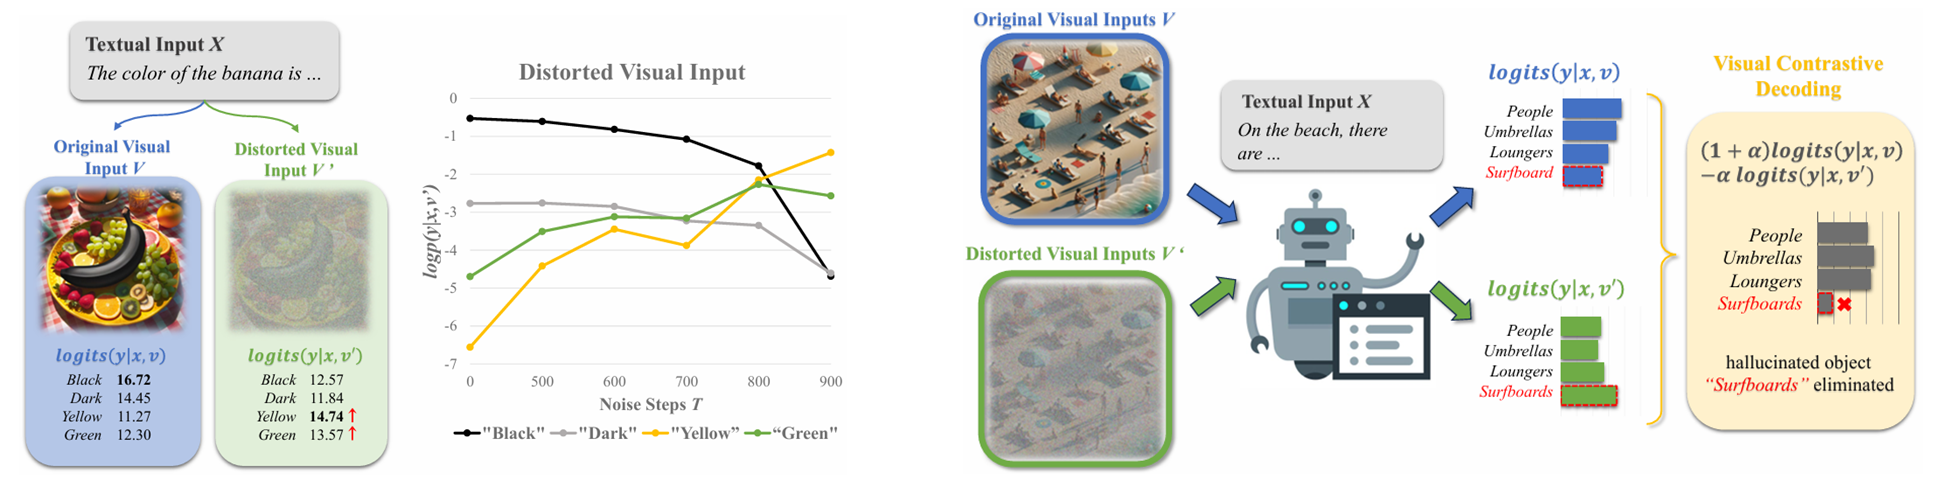
reference: Leng, et al. Mitigating Object Hallucinations in Large Vision-Language Models through Visual Contrastive Decoding. CVPR, 2024

In [8]:
import sys
sys.path.append('/cpfs01/projects-HDD/cfff-906dc71fafda_HDD/ll_25113060022/undergraduates_course_copy/hallucination/advanced/Qwen_VL')
sys.path.append('/cpfs01/projects-HDD/cfff-906dc71fafda_HDD/ll_25113060022/undergraduates_course_copy/hallucination/advanced/vcd_utils')

from transformers import AutoTokenizer 
from Qwen_VL.modeling_qwen import QWenLMHeadModel
from vcd_utils.vcd_add_noise import add_diffusion_noise
from vcd_utils.vcd_sample import evolve_vcd_sampling
evolve_vcd_sampling()

model_path = '/model_weights/Qwen-VL-Chat'
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model_vcd = QWenLMHeadModel.from_pretrained(
        model_path,
        device_map="cuda",
        trust_remote_code=True
        ).eval()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Loading checkpoint shards: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


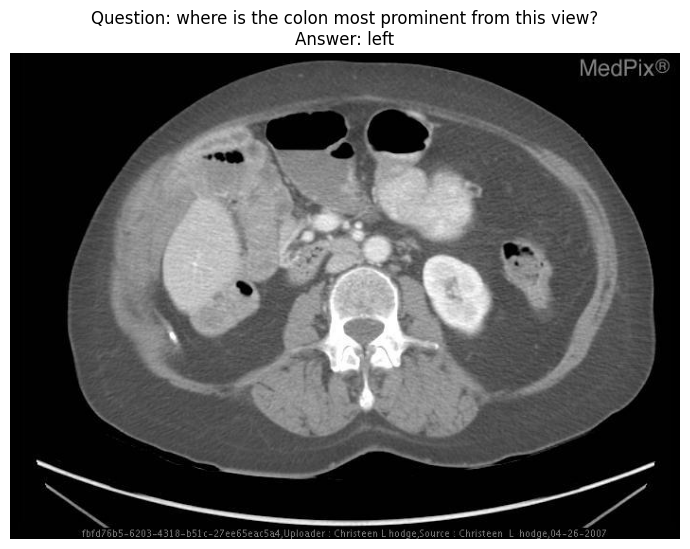

In [9]:
index_3=7

image_path = img_path_head+df['img_path'][index_3]
image = Image.open(image_path).convert("RGB")
image_tensor = model.transformer.visual.image_transform(image).unsqueeze(0).to(model.device)
image_tensor_cd = add_diffusion_noise(image_tensor, noise_step=500)

question, answer = df['question'][index_3], df['answer'][index_3]
question_ = '<img>{}</img>{} Answer:'.format(image_path, question)

tokenizer.padding_side = 'left'
tokenizer.pad_token_id = tokenizer.eod_id
input_ids = tokenizer([question_], return_tensors='pt', padding='longest')

##########################################################################################################################################
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(7, 6))
axes.imshow(image)
axes.set_title(f"Question: {question}\nAnswer: {answer}")
axes.axis('off')

plt.tight_layout()
plt.show()

In [19]:
outputs = model.generate(
                        input_ids=input_ids.input_ids.cuda(),
                        attention_mask=input_ids.attention_mask.cuda(),
                        do_sample=True,
                        max_new_tokens=20,
                        min_new_tokens=1,
                        length_penalty=1,
                        num_return_sequences=1,
                        output_hidden_states=True,
                        use_cache=True,
                        pad_token_id=tokenizer.eod_id,
                        eos_token_id=tokenizer.eod_id,
                        temperature=1.0,
                        top_p=1,
                        top_k=None,
                        output_scores=True,  # 关键：启用分数输出
                        return_dict_in_generate=True  # 关键：返回结构化结果
                        )

predicting_answer = [
                     tokenizer.decode(_[input_ids.input_ids.size(1):].cpu(),
                     skip_special_tokens=True).strip() for _ in outputs.sequences
                    ][0].strip()

outputs_vcd = model_vcd.generate(
                                    input_ids=input_ids.input_ids.cuda(),
                                    attention_mask=input_ids.attention_mask.cuda(),
                                    do_sample=True,
                                    max_new_tokens=20,
                                    min_new_tokens=1,
                                    length_penalty=1,
                                    num_return_sequences=1,
                                    output_hidden_states=True,
                                    use_cache=True,
                                    pad_token_id=tokenizer.eod_id,
                                    eos_token_id=tokenizer.eod_id,
                                    temperature=1.0,
                                    top_p=1,
                                    top_k=None,
                                    images = image_tensor,
                                    images_cd=image_tensor_cd,
                                    cd_beta = 0.1,
                                    cd_alpha = 1,
                                    output_scores=True,  # 关键：启用分数输出
                                    return_dict_in_generate=True  # 关键：返回结构化结果
                                    )
predicting_answer_cd = [
                     tokenizer.decode(_[input_ids.input_ids.size(1):].cpu(),
                     skip_special_tokens=True).strip() for _ in outputs_vcd.sequences
                    ][0].strip()
print(f"{'*'*100}\nQuestion: {question}\nAnswer: {answer}\nPredict: {predicting_answer}\nPredict_cvd: {predicting_answer_cd}")

****************************************************************************************************
Question: where is the colon most prominent from this view?
Answer: left
Predict: right
Predict_cvd: left


In [20]:
logits = torch.cat(outputs.scores, dim=0).float().cpu().detach().numpy()
prob = softmax_1(logits)
prob_max = np.max(prob, axis=1)
average_prob = np.mean(prob_max, axis=0)
maximum_prob = np.max(prob_max, axis=0)

entropy = compute_entropy(prob)
average_entropy = np.mean(entropy, axis=0)[0]
maximum_entropy = np.max(entropy, axis=0)[0]

print(f"{'*'*50}\nhallucination metirc of outputs:")
print(f"average probability = {average_prob}\nmaximum probability = {maximum_prob}")
print(f"average entropy = {average_entropy}\nmaximum entropy = {maximum_entropy}")

###########################################################################################
logits = torch.cat(outputs_vcd.scores, dim=0).float().cpu().detach().numpy()
prob = softmax_1(logits)
prob_max = np.max(prob, axis=1)
average_prob = np.mean(prob_max, axis=0)
maximum_prob = np.max(prob_max, axis=0)

entropy = compute_entropy(prob)
average_entropy = np.mean(entropy, axis=0)[0]
maximum_entropy = np.max(entropy, axis=0)[0]

print(f"{'*'*50}\nhallucination metirc of outputs_cd:")
print(f"average probability = {average_prob}\nmaximum probability = {maximum_prob}")
print(f"average entropy = {average_entropy}\nmaximum entropy = {maximum_entropy}")

**************************************************
hallucination metirc of outputs:
average probability = 0.7589143514633179
maximum probability = 0.8660995364189148
average entropy = 1.211894154548645
maximum entropy = 1.8057494163513184
**************************************************
hallucination metirc of outputs_cd:
average probability = 0.969956636428833
maximum probability = 1.0
average entropy = 0.11360295116901398
maximum entropy = 0.22720590233802795
